In [1]:
%pip install torch==1.12.1    # The results might be slightly different from the reported ones when using other versions.
%pip install bencheval==1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.12.1 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.12.1 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 1.12.1 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 1.12.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

## Preparation

In [2]:
import math
import numpy as np
from scipy.stats import rankdata
from bencheval.data import load_ordinal_benchmark, ordinal_benchmark_list
from bencheval.utils.win_rate import WinningRate
from bencheval.utils.metric import get_rank_diff

new_dataset_name_list = []
for dataset_name in ordinal_benchmark_list:
    data, cols = load_ordinal_benchmark(dataset_name, do_rerank=False)
    wr = WinningRate(data, cols)
    new_rank = rankdata(-wr.get_winning_rate())
    old_rank = np.arange(len(data))
    rank_diff = get_rank_diff(new_rank, old_rank)

    tot = 0
    for c in cols:
        for i in data[c].values:
            if math.isnan(i):
                tot += 1.0

    # if there are too missing values, we skip this benchmark
    if dataset_name != "Random" and tot / len(data) / len(cols) > 0.2:
        print("%s, %.2lf, %.2lf, %.2lf" % (dataset_name, rank_diff[0], rank_diff[1], tot / len(data) / len(cols)))
        continue
    # if the rank difference is too large, we skip this benchmark
    if rank_diff[0] > 0.1:
        print("%s, %.2lf, %.2lf, %.2lf" % (dataset_name, rank_diff[0], rank_diff[1], tot / len(data) / len(cols)))
        continue
    new_dataset_name_list.append(dataset_name)

dataset_name_list = new_dataset_name_list
dataset_name_list




HELM-bias, 0.18, 0.47, 0.36
HELM-calibration, 0.03, 0.15, 0.34
HELM-efficiency, 0.11, 0.32, 0.63
HELM-summarization, 0.17, 0.65, 0.58
HELM-toxicity, 0.25, 0.64, 0.24
HEIM-nsfw, 0.20, 0.40, 0.00
HEIM-black_out, 0.12, 0.30, 0.00
HEIM-originality, 0.49, 0.72, 0.00


['BigCode',
 'HELM-accuracy',
 'HELM-fairness',
 'HELM-robustness',
 'HEIM-alignment_auto',
 'HEIM-quality_auto',
 'HEIM-aesthetics_auto',
 'HEIM-alignment_human',
 'HEIM-nudity',
 'HEIM-quality_human',
 'HEIM-aesthetics_human']

## Trade off between Diversity and Sensitivity

### Sensitivity

In [3]:
from bencheval.data import load_ordinal_benchmark
from bencheval.measures.ordinal import get_sensitivity

sensitivity = {}
for dataset_name in dataset_name_list:
    data, cols = load_ordinal_benchmark(dataset_name)
    sensitivity[dataset_name] = get_sensitivity(data, cols)
    print("%s, %.2lf, %.2lf" % (dataset_name, sensitivity[dataset_name][0], sensitivity[dataset_name][1]))

Episode 999, loss 1.92
BigCode, 0.04, 0.14
Episode 999, loss 3.46
HELM-accuracy, 0.32, 0.67
Episode 999, loss 4.67
HELM-fairness, 0.18, 0.58
Episode 999, loss 3.70
HELM-robustness, 0.26, 0.58
Episode 999, loss 0.60
HEIM-alignment_auto, 0.30, 0.50
Episode 999, loss 1.00
HEIM-quality_auto, 0.20, 0.25
Episode 999, loss 0.39
HEIM-aesthetics_auto, 0.40, 0.50
Episode 999, loss 1.37
HEIM-alignment_human, 0.10, 0.25
Episode 999, loss 0.26
HEIM-nudity, 0.45, 0.75
Episode 999, loss 0.52
HEIM-quality_human, 0.10, 0.25
Episode 999, loss 0.18
HEIM-aesthetics_human, 0.20, 0.25


### Diversity
How largely the rankings on each task differ from each other?

In [4]:
from bencheval.data import load_ordinal_benchmark
from bencheval.measures.ordinal import get_diversity

diversity = {}
for dataset_name in dataset_name_list:
    data, cols = load_ordinal_benchmark(dataset_name)
    diversity[dataset_name] = get_diversity(data, cols)
    print("%s, %.2lf, %.2lf" % (dataset_name, diversity[dataset_name][0], diversity[dataset_name][1]))


BigCode, 0.07, 0.53
HELM-accuracy, 0.27, 0.67
HELM-fairness, 0.30, 0.65
HELM-robustness, 0.28, 0.66
HEIM-alignment_auto, 0.24, 0.57
HEIM-quality_auto, 0.82, 0.84
HEIM-aesthetics_auto, 0.57, 0.67
HEIM-alignment_human, 0.71, 0.76
HEIM-nudity, 0.76, 0.79
HEIM-quality_human, 0.26, 0.53
HEIM-aesthetics_human, 0.44, 0.61


### Dummy Baselines

In [5]:
from bencheval.data import load_ordinal_benchmark
from bencheval.measures.ordinal import get_sensitivity, get_diversity

num_seed = 5
for dataset_name in ["Constant"]:
    for seed in range(num_seed):
        data, cols = load_ordinal_benchmark(dataset_name, seed=seed)
        if dataset_name not in sensitivity.keys():
            sensitivity[dataset_name] = np.array(get_sensitivity(data, cols))
            diversity[dataset_name] = np.array(get_diversity(data, cols))
        else:
            sensitivity[dataset_name] += np.array(get_sensitivity(data, cols))
            diversity[dataset_name] += np.array(get_diversity(data, cols))
    sensitivity[dataset_name] /= float(num_seed)
    diversity[dataset_name] /= float(num_seed)
    print("%s, %.2lf, %.2lf" % (dataset_name, sensitivity[dataset_name][0], sensitivity[dataset_name][1]))
    print("%s, %.2lf, %.2lf" % (dataset_name, diversity[dataset_name][0], diversity[dataset_name][1]))

for dataset_name in ["Random"]:
    for seed in range(num_seed):
        data, cols = load_ordinal_benchmark(dataset_name, seed=seed)
        if dataset_name not in sensitivity.keys():
            sensitivity[dataset_name] = np.array(get_sensitivity(data, cols, inv_indices=np.arange(10)))
            diversity[dataset_name] = np.array(get_diversity(data, cols))
        else:
            sensitivity[dataset_name] += np.array(get_sensitivity(data, cols, inv_indices=np.arange(10)))
            diversity[dataset_name] += np.array(get_diversity(data, cols))
    sensitivity[dataset_name] /= float(num_seed)
    diversity[dataset_name] /= float(num_seed)
    print("%s, %.2lf, %.2lf" % (dataset_name, sensitivity[dataset_name][0], sensitivity[dataset_name][1]))
    print("%s, %.2lf, %.2lf" % (dataset_name, diversity[dataset_name][0], diversity[dataset_name][1]))



Episode 999, loss 13.30
Episode 999, loss 13.30
Episode 999, loss 13.30
Episode 999, loss 13.30
Episode 999, loss 13.30
Constant, 0.00, 0.00
Constant, 0.00, 0.00
Episode 999, loss -0.35


Episode 999, loss -0.34

Random, 0.97, 1.00
Random, 0.99, 0.97


### Save the data

In [6]:
import os
import joblib as jbl

dir_cache = os.path.join(os.getcwd(), ".cache")
os.makedirs(dir_cache, exist_ok=True)
path_sensitivity = os.path.join(dir_cache, "ordinal_sensitivity.jbl")
path_diversity = os.path.join(dir_cache, "ordinal_diversity.jbl")


In [7]:

jbl.dump(sensitivity, path_sensitivity)
jbl.dump(diversity, path_diversity)


['/content/.cache/ordinal_diversity.jbl']

In [8]:
sensitivity = jbl.load(path_sensitivity)
diversity = jbl.load(path_diversity)

### Draw the figures    

In [9]:
!pip install adjustText

Corr=0.68


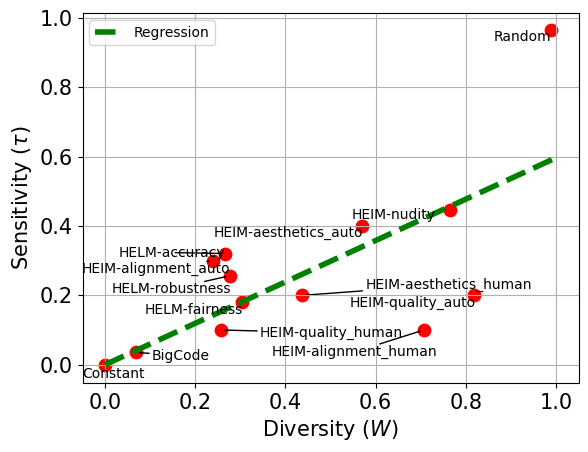

In [10]:
from adjustText import adjust_text
from zarth_utils.drawer import Drawer

all_point_names = [i for i in list(sensitivity.keys()) if "Interpolation" not in i]
x = [diversity[i][0] for i in all_point_names]
y = [sensitivity[i][0] for i in all_point_names]
print("Corr=%.2lf" % float(np.corrcoef(np.array(x), np.array(y))[0, 1]))

drawer = Drawer(unit_row_length=6.4, unit_col_length=4.8)
ax = drawer.draw_one_axes(x, [y], index=1, xlabel="Diversity ($W$)", ylabel=r'Sensitivity ($\tau$)',
                          mode="scatter", use_marker=True, linewidth=80)

texts = []
for i, label in enumerate(all_point_names):
    texts.append(ax.text(x[i], y[i], label, fontsize=10))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black'))
ax.grid()

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

x = np.array(x).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)
clf = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("lin_reg", Ridge(fit_intercept=False, alpha=0.0))
])
clf.fit(x, y)

x2 = np.linspace(0.00, 1.00, 100).reshape(-1, 1)
y2 = clf.predict(x2.reshape(-1, 1)).reshape(-1, 1)
ax.plot(x2, y2, color="green", linewidth=4, linestyle="--", label="Regression")

ax.legend()
drawer.save("ordinal_trade_off_tau.pdf")


Corr=0.53


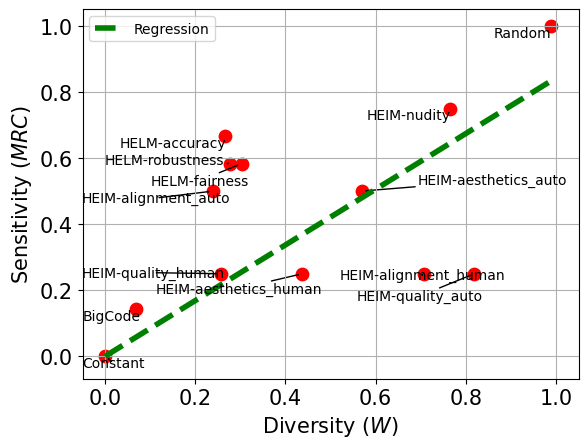

In [11]:
from adjustText import adjust_text
from zarth_utils.drawer import Drawer

all_point_names = [i for i in list(sensitivity.keys()) if "Interpolation" not in i]
x = [diversity[i][0] for i in all_point_names]
y = [sensitivity[i][1] for i in all_point_names]
print("Corr=%.2lf" % float(np.corrcoef(np.array(x), np.array(y))[0, 1]))

drawer = Drawer(unit_row_length=6.4, unit_col_length=4.8)
ax = drawer.draw_one_axes(x, [y], index=1, xlabel=r"Diversity ($W$)", ylabel=r'Sensitivity ($MRC$)',
                          mode="scatter", use_marker=True, linewidth=80)
texts = []
for i, label in enumerate(all_point_names):
    texts.append(ax.text(x[i], y[i], label, fontsize=10))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black'))

ax.grid()

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

x = np.array(x).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)
clf = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("lin_reg", Ridge(fit_intercept=False, alpha=0.0))
])
clf.fit(x, y)

x2 = np.linspace(0.00, 1.00, 100).reshape(-1, 1)
y2 = clf.predict(x2.reshape(-1, 1)).reshape(-1, 1)
ax.plot(x2, y2, color="green", linewidth=4, linestyle="--", label="Regression")

ax.legend()
drawer.save("ordinal_trade_off_MRC.pdf")


## Subset Rank Change Experiment

In [12]:
from bencheval.data import load_ordinal_benchmark

np.random.seed(0)

x = list(np.arange(1, 7))
y1_all, y2_all = [], []
ret_dataset_name_list = []
for dataset_name in dataset_name_list:
    if dataset_name in ["BigCode"]:
        continue
    ret_dataset_name_list.append(dataset_name)
    data, cols = load_ordinal_benchmark(dataset_name)
    old_rank = rankdata(-WinningRate(data, cols).get_winning_rate())
    y1, y2 = [], []
    for subset_size in x:
        min_y = (1, 1)
        for _ in range(1000):
            subset = list(np.random.choice(cols, subset_size, replace=False))
            new_rank = rankdata(-WinningRate(data, subset).get_winning_rate())
            res = get_rank_diff(new_rank, old_rank)
            if res < min_y:
                min_y = res
        y1.append(min_y[0])
        y2.append(min_y[1])
    y1_all.append(y1)
    y2_all.append(y2)

In [13]:
import joblib as jbl

dir_cache = os.path.join(os.getcwd(), ".cache")
os.makedirs(dir_cache, exist_ok=True)

In [14]:
jbl.dump((x, y1_all, y2_all, ret_dataset_name_list), os.path.join(dir_cache, "ordinal_subset_rank_change.jbl"))

['/content/.cache/ordinal_subset_rank_change.jbl']

In [15]:
x1, y1_all, y2_all, ret_dataset_name_list = jbl.load(os.path.join(dir_cache, "ordinal_subset_rank_change.jbl"))

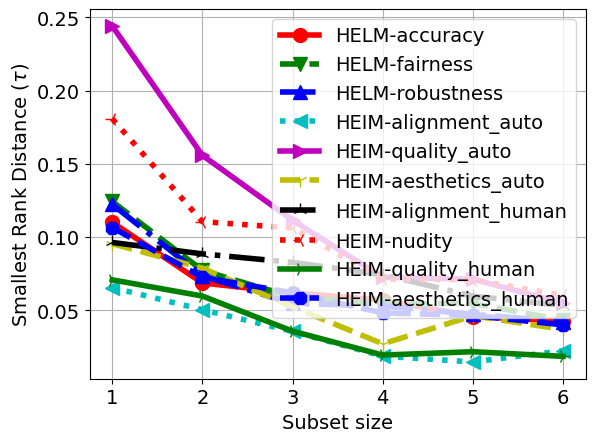

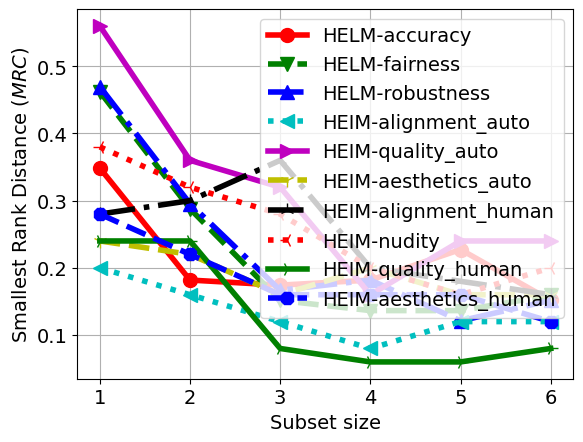

In [16]:

drawer = Drawer(num_col=1, num_row=1, unit_row_length=6.4, unit_col_length=4.8)
ax = drawer.draw_one_axes(x, y1_all, index=1, xlabel="Subset size", ylabel=r"Smallest Rank Distance ($\tau$)",
                          labels=ret_dataset_name_list, mode="plot",
                          linewidth=4, fontsize=14, use_marker=True, markersize=10)
ax.grid()
drawer.save("ordinal_subset_min_tau.pdf")

drawer = Drawer(num_col=1, num_row=1, unit_row_length=6.4, unit_col_length=4.8)
ax = drawer.draw_one_axes(x, y2_all, index=1, xlabel="Subset size", ylabel=r"Smallest Rank Distance ($MRC$)",
                          labels=ret_dataset_name_list, mode="plot",
                          linewidth=4, fontsize=14, use_marker=True, markersize=10)
ax.grid()
drawer.save("ordinal_subset_min_mrc.pdf")


